In [7]:
import torch 
from torch import nn, Tensor

import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

In [ ]:
from einops import repeat

class Flow(nn.Module):
    def __init__(self, dim: int = 2, h: int = 64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim + 1, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, dim))
    
    def forward(self, t: Tensor, x_t: Tensor) -> Tensor:
        return self.net(torch.cat((t, x_t), -1))
    
    def step(self, x_t: Tensor, t_start: Tensor, t_end: Tensor) -> Tensor:
        t_start = t_start.view(1, 1).expand(x_t.shape[0], 1)
        
        return x_t + (t_end - t_start) * self(t=t_start + (t_end - t_start) / 2, x_t= x_t + self(x_t=x_t, t=t_start) * (t_end - t_start) / 2)

# Training

In [47]:
flow = Flow()

optimizer = torch.optim.Adam(flow.parameters(), 1e-2)
loss_fn = nn.MSELoss()

for _ in range(10000):
    x_1 = Tensor(make_moons(256, noise=0.15)[0])
    x_0 = torch.randn_like(x_1)
    t = torch.rand(len(x_1), 1)
    
    x_t = (1 - t) * x_0 + t * x_1
    dx_t = x_1 - x_0
    
    optimizer.zero_grad()
    loss_fn(flow(t=t, x_t=x_t), dx_t).backward()
    optimizer.step()

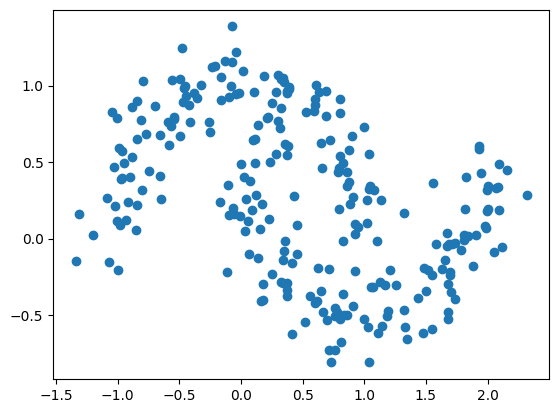

In [29]:
x = Tensor(make_moons(256, noise=0.15)[0])
plt.scatter(x[:, 0] ,x[: ,1])

# Sampling

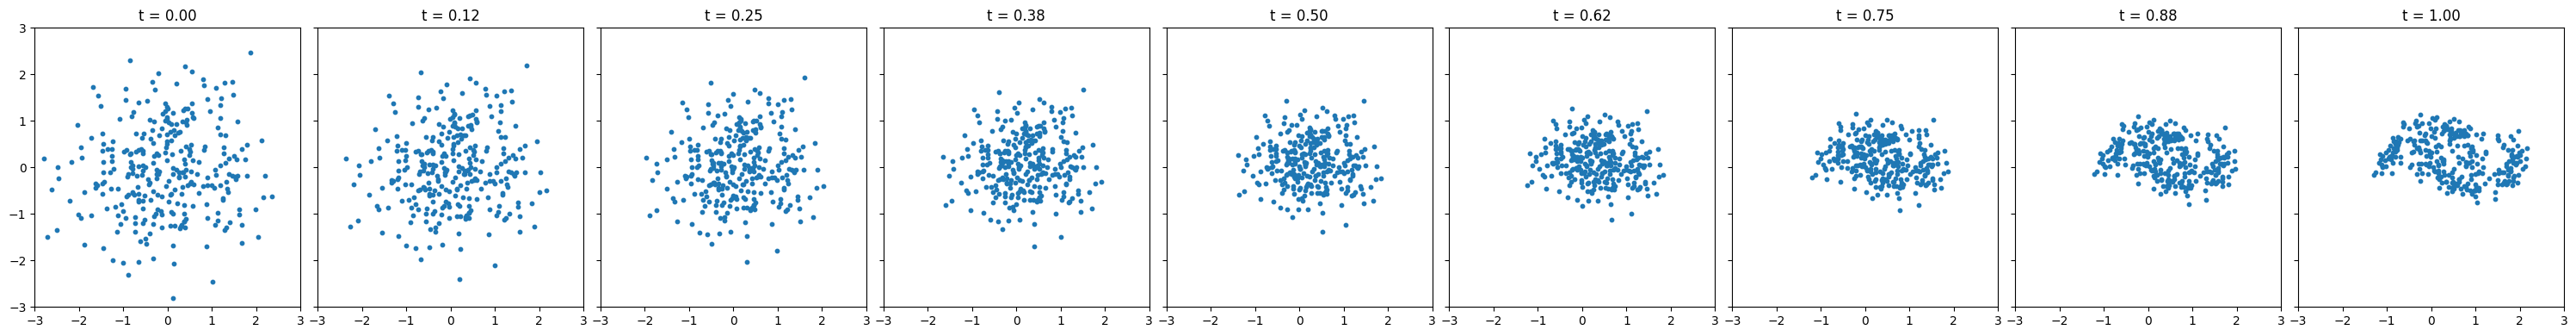

In [48]:
x = torch.randn(300, 2)
n_steps = 8
fig, axes = plt.subplots(1, n_steps + 1, figsize=(30, 4), sharex=True, sharey=True)
time_steps = torch.linspace(0, 1.0, n_steps + 1)

axes[0].scatter(x.detach()[:, 0], x.detach()[:, 1], s=10)
axes[0].set_title(f't = {time_steps[0]:.2f}')
axes[0].set_xlim(-3.0, 3.0)
axes[0].set_ylim(-3.0, 3.0)

for i in range(n_steps):
    x = flow.step(x_t=x, t_start=time_steps[i], t_end=time_steps[i + 1])
    axes[i + 1].scatter(x.detach()[:, 0], x.detach()[:, 1], s=10)
    axes[i + 1].set_title(f't = {time_steps[i + 1]:.2f}')

plt.tight_layout()
plt.show()

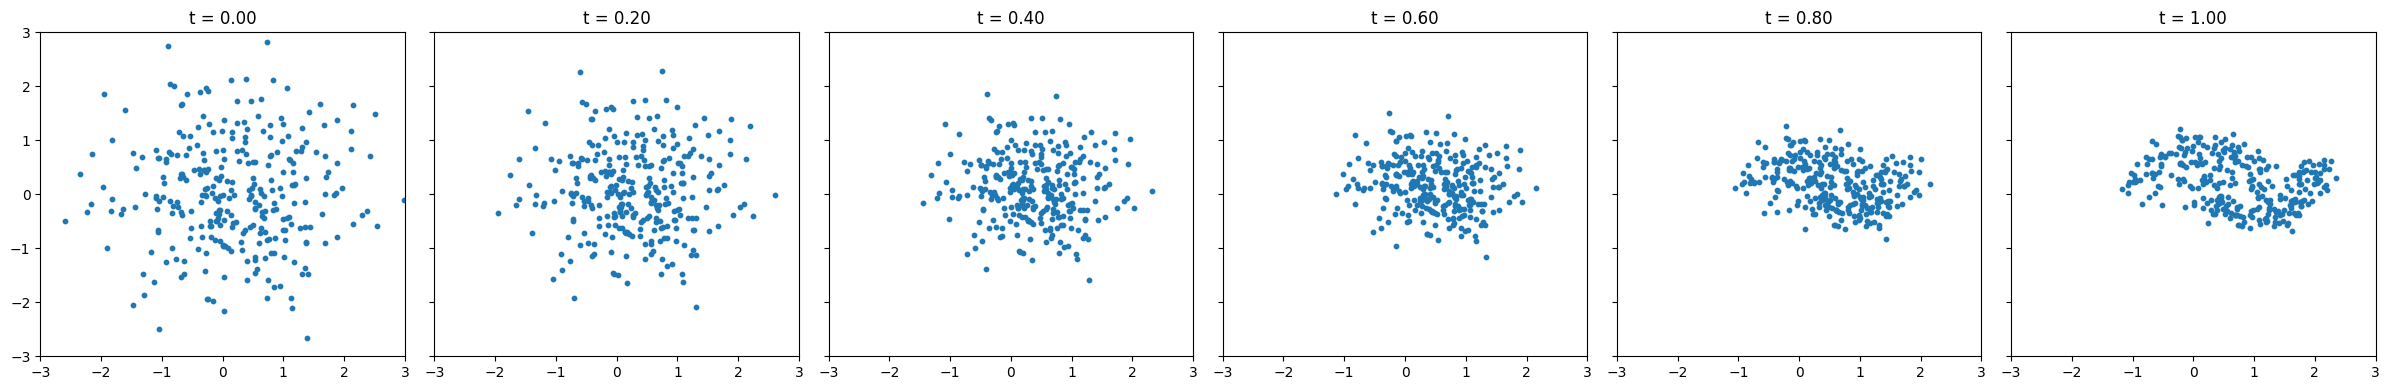

In [49]:
import torch
import matplotlib.pyplot as plt

x = torch.randn(300, 2)
sigma = 1
x = x * sigma

n_steps = 100
plot_every = 20   # <-- Change this value as you like (e.g. 4 means plot every 4 steps)
plot_indices = list(range(0, n_steps + 1, plot_every))
if plot_indices[-1] != n_steps:
    plot_indices.append(n_steps)  # Always plot the last step

fig, axes = plt.subplots(1, len(plot_indices), figsize=(4 * len(plot_indices), 4), sharex=True, sharey=True)
time_steps = torch.linspace(0, 1.0, n_steps + 1)

plot_count = 0
axes[plot_count].scatter(x.detach()[:, 0], x.detach()[:, 1], s=10)
axes[plot_count].set_title(f't = {time_steps[0]:.2f}')
axes[plot_count].set_xlim(-3.0, 3.0)
axes[plot_count].set_ylim(-3.0, 3.0)

for i in range(n_steps):
    x = flow.step(x_t=x, t_start=time_steps[i], t_end=time_steps[i + 1])
    if (i + 1) in plot_indices:
        plot_count += 1
        axes[plot_count].scatter(x.detach()[:, 0], x.detach()[:, 1], s=10)
        axes[plot_count].set_title(f't = {time_steps[i + 1]:.2f}')
        axes[plot_count].set_xlim(-3.0, 3.0)
        axes[plot_count].set_ylim(-3.0, 3.0)

plt.tight_layout()
plt.show()


# Conditional Flow Matching
We now train a simple conditional model using class labels.

In [1]:
import torch 
from torch import nn, Tensor

import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

In [8]:
from einops import repeat

class Flow(nn.Module):
    def __init__(self, dim: int = 2, h: int = 64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim + 2, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, dim))
    
    def forward(self, t: Tensor, c: Tensor, x_t: Tensor ) -> Tensor:
        return self.net(torch.cat((t, c, x_t), -1))
    
    def step(self, x_t: Tensor, t_start: Tensor, t_end: Tensor, c: Tensor) -> Tensor:
        t_start = t_start.view(1, 1).expand(x_t.shape[0], 1)
        
        return x_t + (t_end - t_start) * self(t=t_start + (t_end - t_start) / 2, c = c, x_t= x_t + self(c = c, x_t=x_t, t=t_start) * (t_end - t_start) / 2)

# Training

In [9]:
flow = Flow()

optimizer = torch.optim.Adam(flow.parameters(), 1e-2)
loss_fn = nn.MSELoss()

for _ in range(10000):
    x_1, c = make_moons(256, noise=0.15)
    x_1 = Tensor(x_1)
    c = Tensor(c)
    c = c.view(-1, 1)
    
    x_0 = torch.randn_like(x_1)
    t = torch.rand(len(x_1), 1)
    
    x_t = (1 - t) * x_0 + t * x_1
    dx_t = x_1 - x_0
    
    optimizer.zero_grad()
    loss_fn(flow(t=t, x_t=x_t, c=c), dx_t).backward()
    optimizer.step()

# Sampling

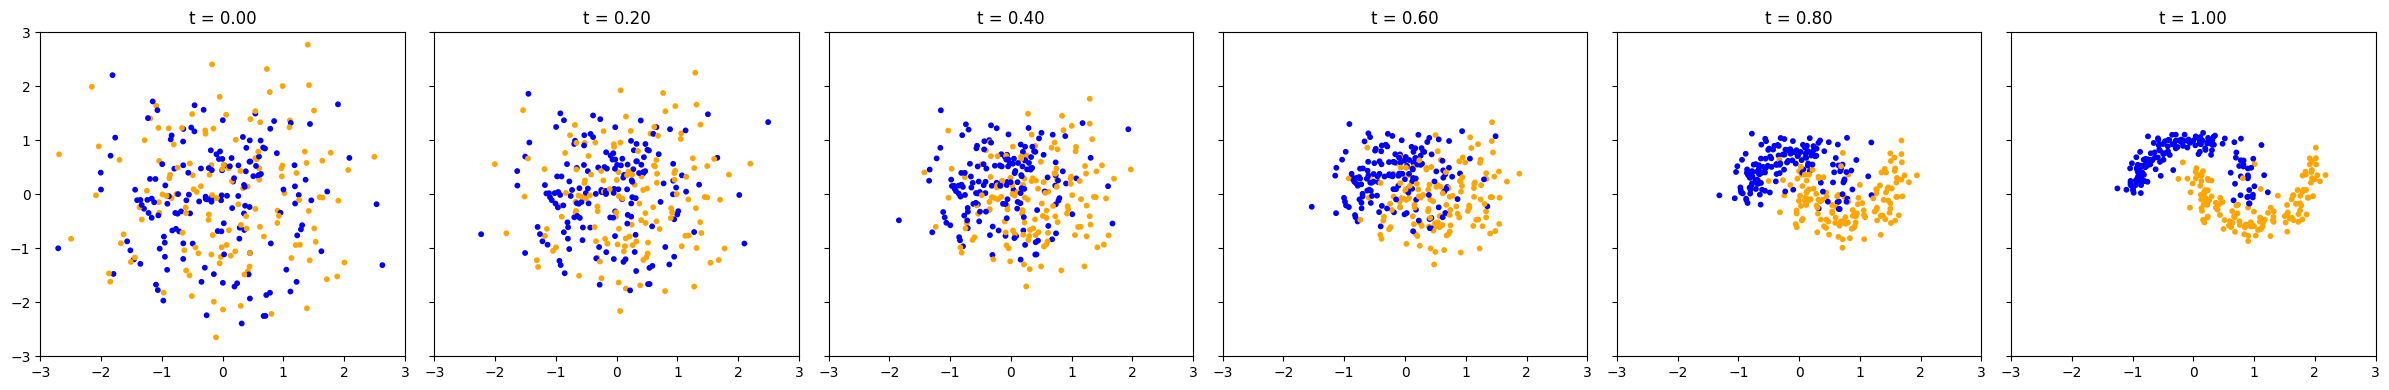

In [15]:
import torch
import matplotlib.pyplot as plt

x = torch.randn(300, 2)
sigma = 1
x = x * sigma

colors = ['blue' if label == 0 else 'orange' for label in c]

n_steps = 100
plot_every = 20 
plot_indices = list(range(0, n_steps + 1, plot_every))
if plot_indices[-1] != n_steps:
    plot_indices.append(n_steps)  # Always plot the last step

fig, axes = plt.subplots(1, len(plot_indices), figsize=(4 * len(plot_indices), 4), sharex=True, sharey=True)
time_steps = torch.linspace(0, 1.0, n_steps + 1)

plot_count = 0
axes[plot_count].scatter(x.detach()[:, 0], x.detach()[:, 1], s=10, c=colors)
axes[plot_count].set_title(f't = {time_steps[0]:.2f}')
axes[plot_count].set_xlim(-3.0, 3.0)
axes[plot_count].set_ylim(-3.0, 3.0)

for i in range(n_steps):
    x = flow.step(x_t=x, t_start=time_steps[i], t_end=time_steps[i + 1], c = c)
    if (i + 1) in plot_indices:
        plot_count += 1
        axes[plot_count].scatter(x.detach()[:, 0], x.detach()[:, 1], s=10, c=colors)
        axes[plot_count].set_title(f't = {time_steps[i + 1]:.2f}')
        axes[plot_count].set_xlim(-3.0, 3.0)
        axes[plot_count].set_ylim(-3.0, 3.0)

plt.tight_layout()
plt.show()
